# Heads or Tails

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

np.set_printoptions(precision=3, suppress=True)

In [5]:
import os

heads_or_tails_train = pd.read_csv(
    os.path.join('/tmp/fizz', 'headsortails_data.csv'))

heads_or_tails_train.head()

,recent,zVol15,z15,z35,z252,beta,sigmaMarket15,sigmaMarket35,sigmaMarket252,zMarket15,zMarket35,zMarket252,result
0,0.0,-0.995429,0.659203,0.659203,0.659203,-0.019197,0.96747,0.836733,0.836733,-0.93033,-1.658435,-1.658435,0.0
1,0.0,-1.249957,-2.023684,-2.023684,-2.023684,0.591371,0.96747,0.836733,0.836733,-0.93033,-1.658435,-1.658435,0.0
2,0.0,-0.510703,-0.506323,-0.506323,-0.506323,0.381148,0.96747,0.836733,0.836733,-0.93033,-1.658435,-1.658435,1.0
3,0.0,-0.579213,-0.598530,-0.598530,-0.598530,1.866220,0.96747,0.836733,0.836733,-0.93033,-1.658435,-1.658435,0.0
4,0.0,-0.022318,1.246597,1.246597,1.246597,-1.408942,0.96747,0.836733,0.836733,-0.93033,-1.658435,-1.658435,1.0


In [6]:
hot_features = heads_or_tails_train.copy().fillna(0)
hot_labels = hot_features.pop('result').astype(int)

In [7]:
msk = np.random.rand(len(hot_features)) < 0.8

hot_features_train = hot_features[msk]
hot_features_test = hot_features[~msk]

hot_labels_train = hot_labels[msk]
hot_labels_test = hot_labels[~msk]

In [8]:
auc_metric = tf.keras.metrics.AUC(
    num_thresholds=200, curve='ROC', summation_method='interpolation', name=None,
    dtype=None, thresholds=None, multi_label=False, label_weights=None
)

In [103]:
precision_metric = tf.keras.metrics.Precision(
    thresholds=[0.6], top_k=None, class_id=None, name=None, dtype=None
)

In [165]:
normalize = preprocessing.Normalization()
hot_model = tf.keras.Sequential([
  normalize,
  layers.Dense(64, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
])

hot_model.compile(loss='binary_crossentropy', optimizer='adam',
                  metrics=['accuracy', auc_metric, precision_metric])

In [166]:
import datetime

log_dir = "/tmp/fizz/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [167]:
hot_model.fit(hot_features_train, hot_labels_train, epochs=20,
              callbacks=[tensorboard_callback])

Epoch 1/20
4619/4619 [==============================] - 5s 1ms/step - loss: 0.6729 - accuracy: 0.6030 - auc: 0.5350 - precision_3: 0.5753
Epoch 2/20
4619/4619 [==============================] - 4s 963us/step - loss: 0.6710 - accuracy: 0.6038 - auc: 0.5219 - precision_3: 0.4286
Epoch 3/20
4619/4619 [==============================] - 4s 945us/step - loss: 0.6701 - accuracy: 0.6037 - auc: 0.5318 - precision_3: 0.5000
Epoch 4/20
4619/4619 [==============================] - 4s 943us/step - loss: 0.6696 - accuracy: 0.6037 - auc: 0.5369 - precision_3: 0.1429
Epoch 5/20
4619/4619 [==============================] - 4s 943us/step - loss: 0.6691 - accuracy: 0.6037 - auc: 0.5389 - precision_3: 0.0000e+00
Epoch 6/20
4619/4619 [==============================] - 4s 945us/step - loss: 0.6685 - accuracy: 0.6042 - auc: 0.5438 - precision_3: 0.8000
Epoch 7/20
4619/4619 [==============================] - 4s 939us/step - loss: 0.6676 - accuracy: 0.6050 - auc: 0.5488 - precision_3: 0.6380
Epoch 8/20
4619/46

In [168]:
print(hot_model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_13 (Normalizat (None, 12)                25        
_________________________________________________________________
dense_47 (Dense)             (None, 64)                832       
_________________________________________________________________
dense_48 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_49 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 65        
Total params: 9,242
Trainable params: 9,217
Non-trainable params: 25
_________________________________________________________________
None


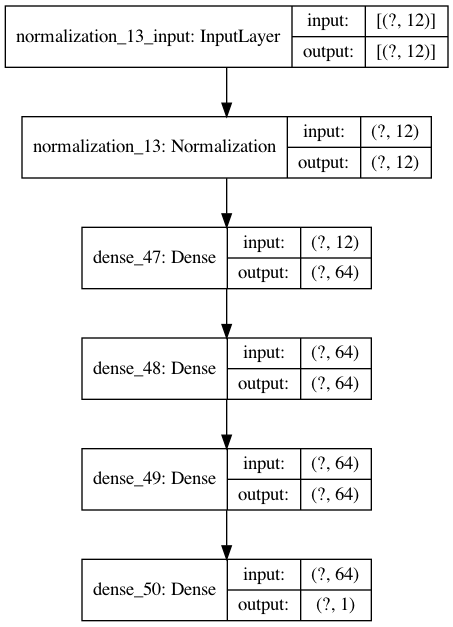

In [169]:
tf.keras.utils.plot_model(
    hot_model,
    to_file="/tmp/fizz/model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

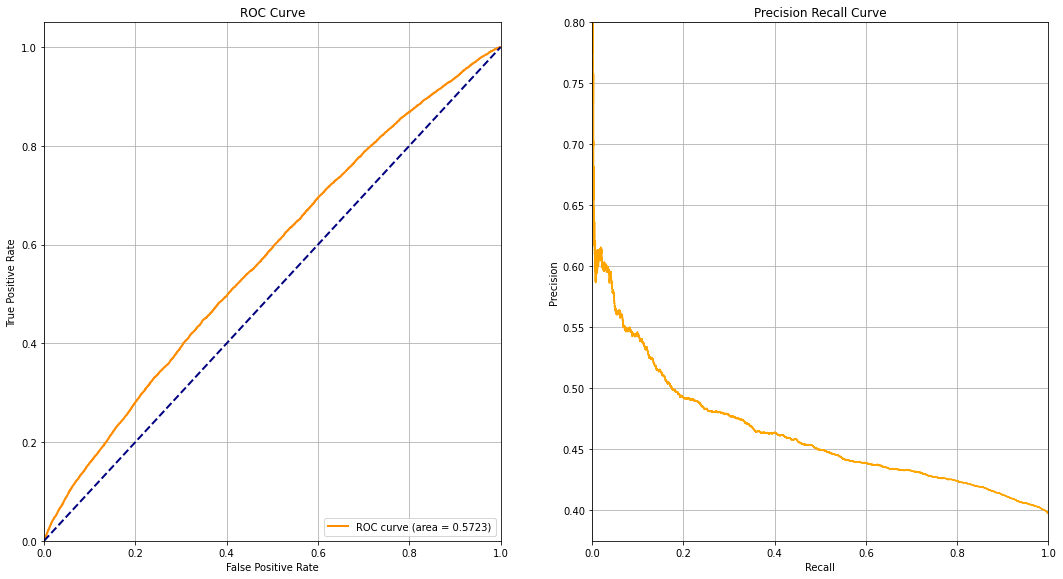

In [179]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

hot_preds_test = hot_model.predict(hot_features_test)

# Get ROC curve FPR and TPR from true labels vs score values
fpr, tpr, _ = metrics.roc_curve(hot_labels_test, hot_preds_test)

# Calculate ROC Area Under the Curve (AUC) from FPR and TPR data points
roc_auc = metrics.auc(fpr, tpr)

# Calculate precision and recall from true labels vs score values
precision, recall, _ = metrics.precision_recall_curve(hot_labels_test, hot_preds_test)

plt.figure(figsize=(18, 9))

plt.subplot(1,2,1)
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)

plt.subplot(1,2,2)
plt.step(recall, precision, color='orange', where='post')
# plt.fill_between(recall, precision, step='post', alpha=0.5, color='orange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.375, 0.8])
plt.xlim([0.0, 1.0])
plt.title('Precision Recall Curve')
plt.grid(True)

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
plt.show()

In [171]:
def find_threshold(labels, preds, target_precision, lb = 0.0, ub = 1.0):
  mp = (lb + ub) / 2.0
  if ub - lb < 0.001:
    return mp
  precision = metrics.precision_score(labels, preds >= mp)
  if precision < target_precision:
    return find_threshold(labels, preds, target_precision, mp, ub)
  return find_threshold(labels, preds, target_precision, lb, mp)

In [172]:
threshold = find_threshold(hot_labels_test, hot_preds_test, 0.5)
print(threshold)

0.47802734375


In [173]:
metrics.precision_score(hot_labels_test, hot_preds_test >= threshold)

0.5004899078973153

In [174]:
metrics.confusion_matrix(hot_labels_test, hot_preds_test >= threshold)

array([[19675,  2549],
       [12087,  2554]])

In [177]:
thresholds = [find_threshold(hot_labels_test, hot_preds_test, 0.5 + 0.1 * i) for i in range(0, 5)]
print(thresholds)

[0.47802734375, 0.58642578125, 0.73291015625, 0.79052734375, 0.83056640625]


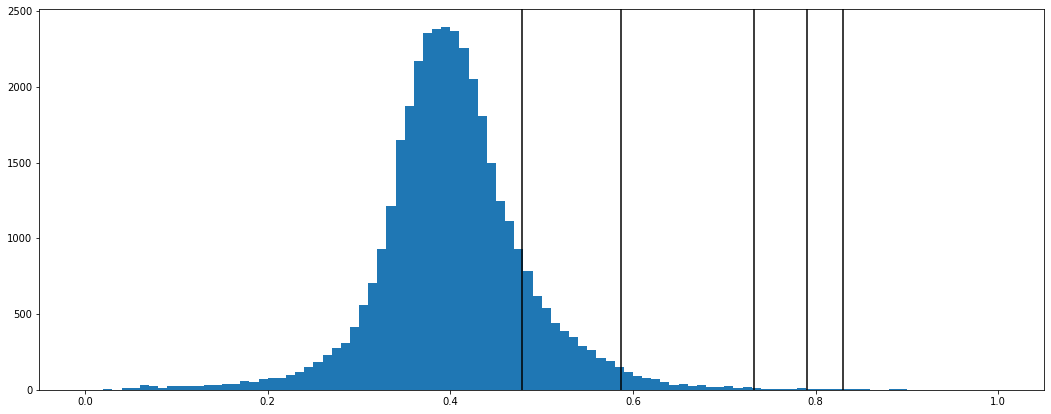

In [178]:
plt.figure(figsize=(18, 7))
plt.hist(hot_preds_test, bins=[0.01 * i for i in range(0, 101)])
for next_threshold in thresholds:
  plt.axvline(x=next_threshold, color="black")
plt.show()

In [182]:
hot_model.save("/tmp/fizz/headsortails_model")

INFO:tensorflow:Assets written to: /tmp/fizz/headsortails_model/assets
